# Общий конвейер

In [1]:
import numpy as np
import keras
import pandas as pd

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D

from keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import TweetTokenizer

import pyodbc

from re import sub

Using TensorFlow backend.


## 1. Загрузка данных

In [2]:
import pandas
df_train = pandas.read_csv("data/train.csv")
df_test  = pandas.read_csv("data/test.csv")
df_val   = pandas.read_csv("data/val.csv")

In [3]:
df_train.head()

,id,text,class
0,0,"оооо, пошёл я:d",1
1,1,"остальные, к слову, из твоего - я тоже не ви...",0
2,2,"все, что вы не знали о кофе, но понтовались и ...",1
3,3,в последнее время не могу побороть свою лень. ...,0
4,4,"ахаххаха,дададад:* ибо нехуй тут ей:d:*",1


## 2. Токенизация
Кодируем слова индексами (вычисленными по частоте употребления).
Using russian http://www.ruscorpora.ru/en/

from keras.preprocessing.text import Tokenizer Убираем, потому что он режет символы пунктуации
#### Step 1. Clear dataset. 
Select words one by one. Symbols are meaningful because of smiles and emotions.

We will create a HashMap by using a Python dictionary to store the word frequencies of a book.
A dictionary is an associative array (also known as hashes).
Any key of the dictionary is associated, or mapped, to a value.
The values of a dictionary can be any Python data type, so dictionaries are unordered key-value-pairs.

By creating the dictionary, we will store the words as the keys and the value will represent the count. By doing this, we can retrieve any word without having to recount every single word.

#### Step 2. Select meaningful words.
#### Step 3. Calculate frequency of each word
#### Step 4. Replace words by indexes

In [4]:
import nltk
import string
from nltk.corpus import stopwords
from nltk import pos_tag, word_tokenize

import gensim
from gensim.models.word2vec import Word2Vec # the word2vec model gensim class
LabeledSentence = gensim.models.doc2vec.TaggedDocument

c:\users\gorda\anaconda3\envs\tensorflow\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [5]:
hash_map = {}


In [6]:
max_len = 15

In [7]:
class SentimentAnalysis:
    max_words = 2000
    batch_size = 32
    epochs = 30
    max_len = 15
    cnstr = 'Trusted_Connection=yes;DRIVER={SQL Server};SERVER=GORDAPC;DATABASE=positive;UID=sa;PWD=49649952'
    #'Trusted_Connection=yes;DRIVER={SQL Server};SERVER=GORDAPC\MSSQLSERVER2017;DATABASE=InnaDB;UID=sa;PWD=49649952'
    map = {}
    x_train, y_train, x_test, y_test = ([] for i in range(4))

    def data_generator(self, constring, query):
        cnxn = pyodbc.connect(constring)
        cursor = cnxn.cursor()
        cursor.execute(query)

        y, t = [], []
        for row in cursor:
            r_text = row.ttext
            r_type = row.ttype
            y.append(r_text)
            t.append(r_type)

            if len(y) == self.batch_size:
                npx = np.array(y)
                npy = np.array(t)
                yield npx, npy
                y, t = [], []
        pyodbc.Connection.close(cnxn)
    
    def tokenize(self, file_text):
        try:
            #firstly let's apply nltk tokenization
            #tokens = nltk.word_tokenize(file_text)
       
            #\n
            #file_text = sub(r'\n', " ", file_text)

            #print('tokenize ', type(file_text))
            tknzr = TweetTokenizer()
            tokens = tknzr.tokenize(file_text)
            
            tokens = filter(lambda t: not t.startswith('@'), tokens)
            tokens = filter(lambda t: not t.startswith('#'), tokens)
            tokens = filter(lambda t: not t.startswith('http'), tokens)
        
            #let's delete punctuation symbols
            stop_words = ([',','\\','/','*','','-','http',';',':','@',',','.','#','"','n','—','_','+','RT'])
            tokens = [i for i in tokens if ( i not in stop_words )]
            
            tokens = [i for i in tokens if not i.isdigit() ]

            #deleting stop_words
            stop_words = list(set(stopwords.words('russian'))-set(['не','лучше','больше','никогда','хорошо']))
            #stop_words.extend(['что', 'это', 'так', 'вот', 'быть', 'в', '—', 'к', 'на', 'http', 'чем', 'х','ж','же','\\n','\\nя'
            #                   ,'еще','ещё','d','rt'])

            tokens = [i for i in tokens if ( i not in stop_words )]

            #cleaning words
            #tokens = [i.replace("«", "").replace("»", "") for i in tokens]
            
            return tokens
        except:
            return 'NC'
    
    def map_words(self, tokens):
        if tokens is not None:
            for word in tokens:
                word = word.lower()
                # Word Exist?
                if word in hash_map:
                    hash_map[word] = hash_map[word] + 1
                else:
                    hash_map[word] = 1

            return hash_map
        else:
            return None
        
    def frequency_mapping(self):
        hash_map.clear()

        query = "SELECT [ttext], [ttype] FROM [dbo].[mixedmessages]"
        pdg = self.data_generator(self.cnstr, query)


        for current_set in pdg:
            for sentence in current_set[0]:
                words = self.tokenize(sentence)
                self.map = self.map_words(words)
        most_popular_words = sorted(self.map, key=self.map.get, reverse=True)[:self.max_words]
        indexes = list(range(0, self.max_words))
        self.map = dict( zip( most_popular_words, indexes))
        #{key: value for key, value in self.map.items() if key in most_popular_words}
    
    def get_frequency(self, word):
        for word in word_list:
            print( str(self.map.get(word,0)))
    
    def vectorize(self,data):
        max_frequency = max(self.map.values())
        
        x_data = []
        
        for index, row in data.iterrows():
            if pd.isnull(row.text):
                words = sa.tokenize('')
            else:
                words = sa.tokenize(row.text)
            w = []
            #print(words)
            for word in words:
                #print(word, map.get(word,0))
                w.append(self.map.get(word,0))
            x_data.append(w)

        x_data = np.array(x_data)
        x_data = pad_sequences(x_data, maxlen=self.max_len)
        #print(x_train)
        return x_data
    
    def tokenize_message(self, string):
        words = self.tokenize(string)
        res = []
        for word in words:
            res.append(self.map.get(word,0))
        ntm = np.array([res])

        nres = pad_sequences(ntm, maxlen=self.max_len)
            #res.append([word_2_ind[w] for w in sent.split(' ')])
        return nres#np.pad(ntm, (maxlen-len(ntm),0),'constant', constant_values=(0))
    
    def getRating(self, value):
        return {
             value < 0.2: 'Крайне негативная оценка',
             0.2 <= value < 0.4: 'Негативная оценка',
             0.4 <= value < 0.6: 'Нейтральная оценка',
             0.6 <= value < 0.8: 'Положительная оценка',
             0.8 <= value:       'Крайне положительная оценка'
        }[True]
    
    def sentiment(self, model, text):
        inp = np.array(self.tokenize_message(text), dtype=np.int32)
        p = model.predict(inp)
        return self.getRating(p[0][0]), p[0][0]
    
    def postprocess(self, data, n=1000000):
        data = data.head(n)
        
        data['tokens'] = data['text'].progress_map(self.tokenize)  ## progress_map is a variant of the map function plus a progress bar. Handy to monitor DataFrame creations.
        data = data[data.tokens != 'NC']
        data.reset_index(inplace=True)
        data.drop('index', inplace=True, axis=1)
        return data

    def frequency_mapping_(self):
        hash_map.clear()

        query = "SELECT [ttext], [ttype] FROM [dbo].[mixedmessages]"
        pdg = self.data_generator(self.cnstr, query)


        for current_set in pdg:
            for sentence in current_set[0]:
                words = self.tokenize(sentence)
                self.map = self.map_words(words)
        most_popular_words = sorted(self.map, key=self.map.get, reverse=True)[:self.max_words]
        indexes = list(range(0, self.max_words))
        self.map = dict( zip( most_popular_words, indexes))

In [8]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")


In [9]:
sa = SentimentAnalysis()

### Building the word2vec model

In [10]:
train_data = sa.postprocess(df_train)
val_data = sa.postprocess(df_val)

progress-bar: 100%|██████████████████████████████████████████████████████████| 181467/181467 [00:57<00:00, 3153.67it/s]
c:\users\gorda\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
progress-bar: 100%|████████████████████████████████████████████████████████████| 22683/22683 [00:07<00:00, 3094.33it/s]


In [11]:
val_data.head()

,id,text,class,tokens
0,181467,скоро cкоро уже все начнут покупать новогодние...,1,"[скоро, cкоро, начнут, покупать, новогодние, ё..."
1,181468,"любовь странное чувство,то любишь,то ненавидеш...",0,"[любовь, странное, чувство, любишь, ненавидешь..."
2,181469,записывали эфир с большим человеком. реально о...,1,"[записывали, эфир, большим, человеком, реально..."
3,181470,"химичка,спалила походу(",0,"[химичка, спалила, походу, (]"
4,181471,мой хороооший:3 olegmiami5 с днем рождения!))...,1,"[хороооший, olegmiami, днем, рождения, !, ), )..."


In [12]:
x_train = np.array(train_data.tokens)
y_train = np.array(train_data['class'])

x_test = np.array(val_data.tokens)
y_test = np.array(val_data['class'])

Before feeding lists of tokens into the word2vec model, we must turn them into LabeledSentence objects beforehand. Here's how to do it:



In [13]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (181443,)
x_test shape: (22677,)


In [14]:
def labelizeTweets(tweets, label_type):
    labelized = []
    for i,v in tqdm(enumerate(tweets)):
        label = '%s_%s'%(label_type,i)
        labelized.append(LabeledSentence(v, [label]))
    return labelized

x_train = labelizeTweets(x_train, 'TRAIN')
x_test = labelizeTweets(x_test, 'TEST')

181443it [00:00, 495751.48it/s]
22677it [00:00, 889325.32it/s]


In [21]:
x_train[14:17]

[TaggedDocument(words=['пришло', 'время', 'возвращаться', 'мою', 'любимую', 'страну', ':)', 'первое', 'сделаю', 'это', 'проявлю', 'пленку', '!'], tags=['TRAIN_14']),
 TaggedDocument(words=['никто', 'друзей', 'не', 'пошел', '('], tags=['TRAIN_15']),
 TaggedDocument(words=['композиция', 'золотые', 'линии', ')'], tags=['TRAIN_16'])]

Now we are ready to build the word2vec model from x_train i.e. the corpus.

In [16]:
tweet_w2v = Word2Vec(size=512, min_count=10)
tweet_w2v.build_vocab([x.words for x in tqdm(x_train)])
tweet_w2v.train([x.words for x in tqdm(x_train)], total_examples=tweet_w2v.corpus_count, epochs=tweet_w2v.epochs)

100%|█████████████████████████████████████████████████████████████████████| 181443/181443 [00:00<00:00, 3423500.76it/s]


(5177505, 8458660)

In [17]:
tweet_w2v.wv['хороший']

array([ -4.84775811e-01,  -2.02515066e-01,  -3.24875116e-01,
        -7.58991018e-02,   4.48658943e-01,   2.05963895e-01,
         1.60541445e-01,  -1.27083123e-01,  -4.05149348e-03,
        -1.12929635e-01,   6.65242150e-02,  -1.54863372e-01,
         1.25821903e-01,  -3.53133410e-01,  -2.36356929e-01,
         1.28205836e-01,   3.29422802e-01,  -6.69104606e-02,
        -7.24445209e-02,  -2.64091879e-01,  -4.01458889e-01,
        -2.46305987e-02,  -1.49660498e-01,  -2.73069203e-01,
        -6.11310780e-01,   2.77889639e-01,   1.68423966e-01,
        -3.01596373e-01,   2.97776848e-01,  -1.87456295e-01,
        -6.99449331e-02,  -2.04128295e-01,  -3.16985279e-01,
        -1.54065728e-01,  -6.64844224e-03,  -1.56552210e-01,
         2.42074251e-01,  -1.88119799e-01,   1.69587031e-01,
         1.36620075e-01,  -1.75825313e-01,  -6.03250802e-01,
        -2.34590858e-01,  -3.08934301e-01,  -2.85698567e-02,
        -7.19273761e-02,  -1.29434377e-01,  -2.18615904e-01,
        -2.84732599e-03,

In [18]:
tweet_w2v.wv.most_similar('хороший')

[('крутой', 0.9412223100662231),
 ('классный', 0.9401661157608032),
 ('добрый', 0.8919504880905151),
 ('шикарный', 0.8890976905822754),
 ('замечательный', 0.8841381072998047),
 ('приятный', 0.8748196363449097),
 ('прекрасный', 0.8747985363006592),
 ('счастливый', 0.8644788861274719),
 ('офигенный', 0.8638586401939392),
 ('отличный', 0.851129412651062)]

In [19]:
tweet_w2v.wv.most_similar('фильм')

[('сериал', 0.9124467372894287),
 ('класс', 0.7722108960151672),
 ('сезон', 0.701657772064209),
 ('момент', 0.6966123580932617),
 ('вечер', 0.6921699047088623),
 ('офигенский', 0.6899518966674805),
 ('понравился', 0.6898279190063477),
 ('используем', 0.6867188215255737),
 ('смотрела', 0.6815809607505798),
 ('посмотрел', 0.6779988408088684)]

from sklearn.feature_extraction.text import TfidfVectorizer

In [103]:
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras import backend as K

In [109]:
df_train.shape

(181467, 3)

In [119]:
X_train = np.zeros((df_train.shape[0], max_len, 512), dtype=K.floatx())
Y_train = np.zeros((df_train.shape[0]), dtype=np.int32)
X_test = np.zeros((df_test.shape[0], max_len, 512), dtype=K.floatx())
Y_test = np.zeros((df_test.shape[0]), dtype=np.int32)

def buildWordVector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += tweet_w2v[word].reshape((1, size)) * tfidf[word]
            count += 1.
        except KeyError: # handling the case where the token is not
                         # in the corpus. useful for testing.
            continue
    if count != 0:
        vec /= count
    return vec

from sklearn.preprocessing import scale
train_vecs_w2v = np.concatenate([buildWordVector(z, sa.max_words) for z in tqdm(map(lambda x: x.words, x_train))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([buildWordVector(z, sa.max_words) for z in tqdm(map(lambda x: x.words, x_test))])
test_vecs_w2v = scale(test_vecs_w2v)

train_vecs_w2v.shape

In [102]:
print('Building model sequentially ...')
model = Sequential()
model.add(LSTM(128,input_shape=(train_vecs_w2v.shape[0],), dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

Building model sequentially ...


ValueError: Input 0 is incompatible with layer lstm_5: expected ndim=3, found ndim=2

In [88]:
model.layers

In [89]:
print(model.to_yaml())

backend: tensorflow
class_name: Sequential
config:
- class_name: LSTM
  config:
    activation: tanh
    activity_regularizer: null
    batch_input_shape: !!python/tuple [null, 181443, 2000]
    bias_constraint: null
    bias_initializer:
      class_name: Zeros
      config: {}
    bias_regularizer: null
    dropout: 0.2
    dtype: float32
    go_backwards: false
    implementation: 1
    kernel_constraint: null
    kernel_initializer:
      class_name: VarianceScaling
      config: {distribution: uniform, mode: fan_avg, scale: 1.0, seed: null}
    kernel_regularizer: null
    name: lstm_2
    recurrent_activation: hard_sigmoid
    recurrent_constraint: null
    recurrent_dropout: 0.2
    recurrent_initializer:
      class_name: Orthogonal
      config: {gain: 1.0, seed: null}
    recurrent_regularizer: null
    return_sequences: false
    return_state: false
    stateful: false
    trainable: true
    unit_forget_bias: true
    units: 128
    unroll: false
    use_bias: true
- class_

In [90]:
import graphviz
import pydot_ng as pydot
print (pydot.find_graphviz())

{'dot': 'C:\\Program Files (x86)\\Graphviz2.38\\bin\\dot.exe', 'twopi': 'C:\\Program Files (x86)\\Graphviz2.38\\bin\\twopi.exe', 'neato': 'C:\\Program Files (x86)\\Graphviz2.38\\bin\\neato.exe', 'circo': 'C:\\Program Files (x86)\\Graphviz2.38\\bin\\circo.exe', 'fdp': 'C:\\Program Files (x86)\\Graphviz2.38\\bin\\fdp.exe', 'sfdp': 'C:\\Program Files (x86)\\Graphviz2.38\\bin\\sfdp.exe'}


In [91]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

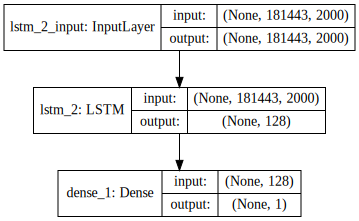

In [92]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [93]:
from keras.objectives import binary_crossentropy
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [94]:
from keras.callbacks import TensorBoard  
tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
from keras.callbacks import EarlyStopping  
early_stopping=EarlyStopping(monitor='val_loss', patience=3)  


history = model.fit(x_train, y_train,
                    batch_size=sa.batch_size,
                    epochs=sa.epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[tensorboard, early_stopping])

ValueError: Error when checking input: expected lstm_2_input to have 3 dimensions, but got array with shape (181443, 2000)

In [57]:
score = model.evaluate(x_val, y_val, batch_size=sa.batch_size, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

22683/22683 [==============================] - 1s 37us/step


Test score: 0.0650629415337
Test accuracy: 0.986686064454


In [58]:
results = model.predict(x_test, batch_size=sa.batch_size, verbose=1)

22684/22684 [==============================] - 1s 27us/step


In [66]:
#sa.sentiment(model,'Мне не нравится фильм. Сюжет совсем неинтересный и актеры сыграли плохо')

#x_text = pad_sequences(x_text, maxlen=sa.max_len)

#model.predict(x_text)
inp = np.array(sa.tokenize_message('Мне нравится фильм. Отличная игра актеров и интересный сюжет'), dtype=np.int32)
p = model.predict(inp)
p

array([[ 0.98367172,  0.01632828]], dtype=float32)

In [60]:
print('x_train shape:', x_text.shape)

NameError: name 'x_text' is not defined

In [67]:
df_train['text'][0]

'Делаю пробное печенье по рецепту makeupkaty , пока что без формы) http://t.co/bRZjtMdXyd'